In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
!pip3 install face_recognition

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=fdcd6544937c2e4b31ed5b66e2724b2a21d4ce3ff11a85be663fa8c96c0d4686
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
#import libraries
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models

In [ ]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [ ]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [ ]:
#!pip3 install face_recognition
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

/content/drive/My Drive/Dataset/004_982.mp4


<ipython-input-5-df0db4bf4c35>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = sm(logits)


confidence of prediction: 76.16309523582458


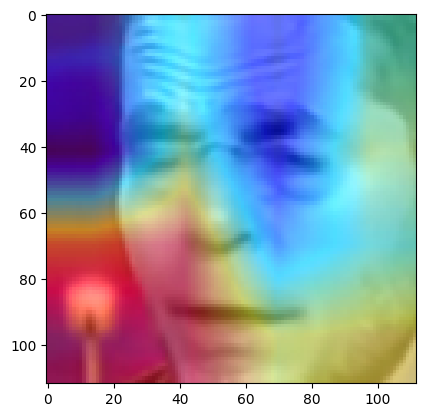

FAKE


In [ ]:
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
# path_to_videos = ['/content/drive/My Drive/Balanced_Face_only_data/aagfhgtpmv.mp4',
#                                    '/content/drive/My Drive/Balanced_Face_only_data/aczrgyricp.mp4',
#                                    '/content/drive/My Drive/Balanced_Face_only_data/agdkmztvby.mp4',
#                                    '/content/drive/My Drive/Balanced_Face_only_data/abarnvbtwb.mp4']

# path_to_videos = ['/content/drive/My Drive/Youtube_Face_only_data/000_003.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/000.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/002_006.mp4',
#                   '/content/drive/My Drive/Youtube_Face_only_data/002.mp4'


# ]

path_to_videos= ["/content/drive/My Drive/Dataset/004_982.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cuda()
path_to_model = '/content/drive/My Drive/checkpoint.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL")
  else:
    print("FAKE")

In [ ]:
#Optional : If you want to pass full frame for prediction instead of face cropped frame
#code for full frame processing
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image